In [14]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import gpytorch
from tqdm.notebook import trange
import heapq
import math
import pickle
import itertools
from algorithms.cd import con_div
from algorithms.ccr import con_conv_rate
from utils.class_imbalance import get_classes, class_proportion

## Dataset

In [16]:
def sample_GMM(means, covs, num_samples):
    """
    Samples equally from clusters of normal distributions.
    """
    assert(means.shape[0] == covs.shape[0])
    assert(means.shape[1] == covs.shape[1])
    assert(covs.shape[1] == covs.shape[2])
    
    n = means.shape[0]
    d = means.shape[1]
    samples = np.zeros((num_samples, d))
    clusters = np.zeros(num_samples, dtype=np.int32)
    
    for i in range(num_samples):
        cluster = np.random.randint(n)
        samples[i] = np.random.multivariate_normal(means[cluster], covs[cluster], check_valid='raise')
        clusters[i] = cluster
    
    return samples, clusters

In [17]:
num_clusters = 5
d = 2
num_samples = 1000

In [18]:
np.random.seed(2)

In [19]:
means = np.random.uniform(size=(num_clusters, d))
covs = np.zeros((num_clusters, d, d))
for i in range(num_clusters):
    covs[i] = np.eye(d)/200

In [20]:
train_sets = np.zeros((num_clusters, num_samples, d))
test_sets = np.zeros((num_clusters, num_samples, d))

In [21]:
for i in range(num_clusters):
    train_sets[i] = np.random.multivariate_normal(means[i], covs[i], size=(num_samples), check_valid='raise')
    test_sets[i] = np.random.multivariate_normal(means[i], covs[i], size=(num_samples), check_valid='raise')

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)
for i in range(num_clusters):
    plt.scatter(train_sets[i, :, 0], train_sets[i, :, 1], s=2, color=cm.get_cmap('Set1')(i*(1/9)), label="{0}".format(i))
    plt.legend()

## Unequal split

In [25]:
num_parties = 5

In [26]:
unequal_prop = np.array([[0.2, 0.2, 0.2, 0.2, 0.2], 
                         [0.2, 0.2, 0.2, 0.2, 0.2],
                         [0.6, 0.4, 0.0, 0.0, 0.0],
                         [0.0, 0.2, 0.6, 0.2, 0.0],
                         [0.0, 0.0, 0.0, 0.4, 0.6]])

In [27]:
unequal_datasets = split_proportions(train_sets, unequal_prop)

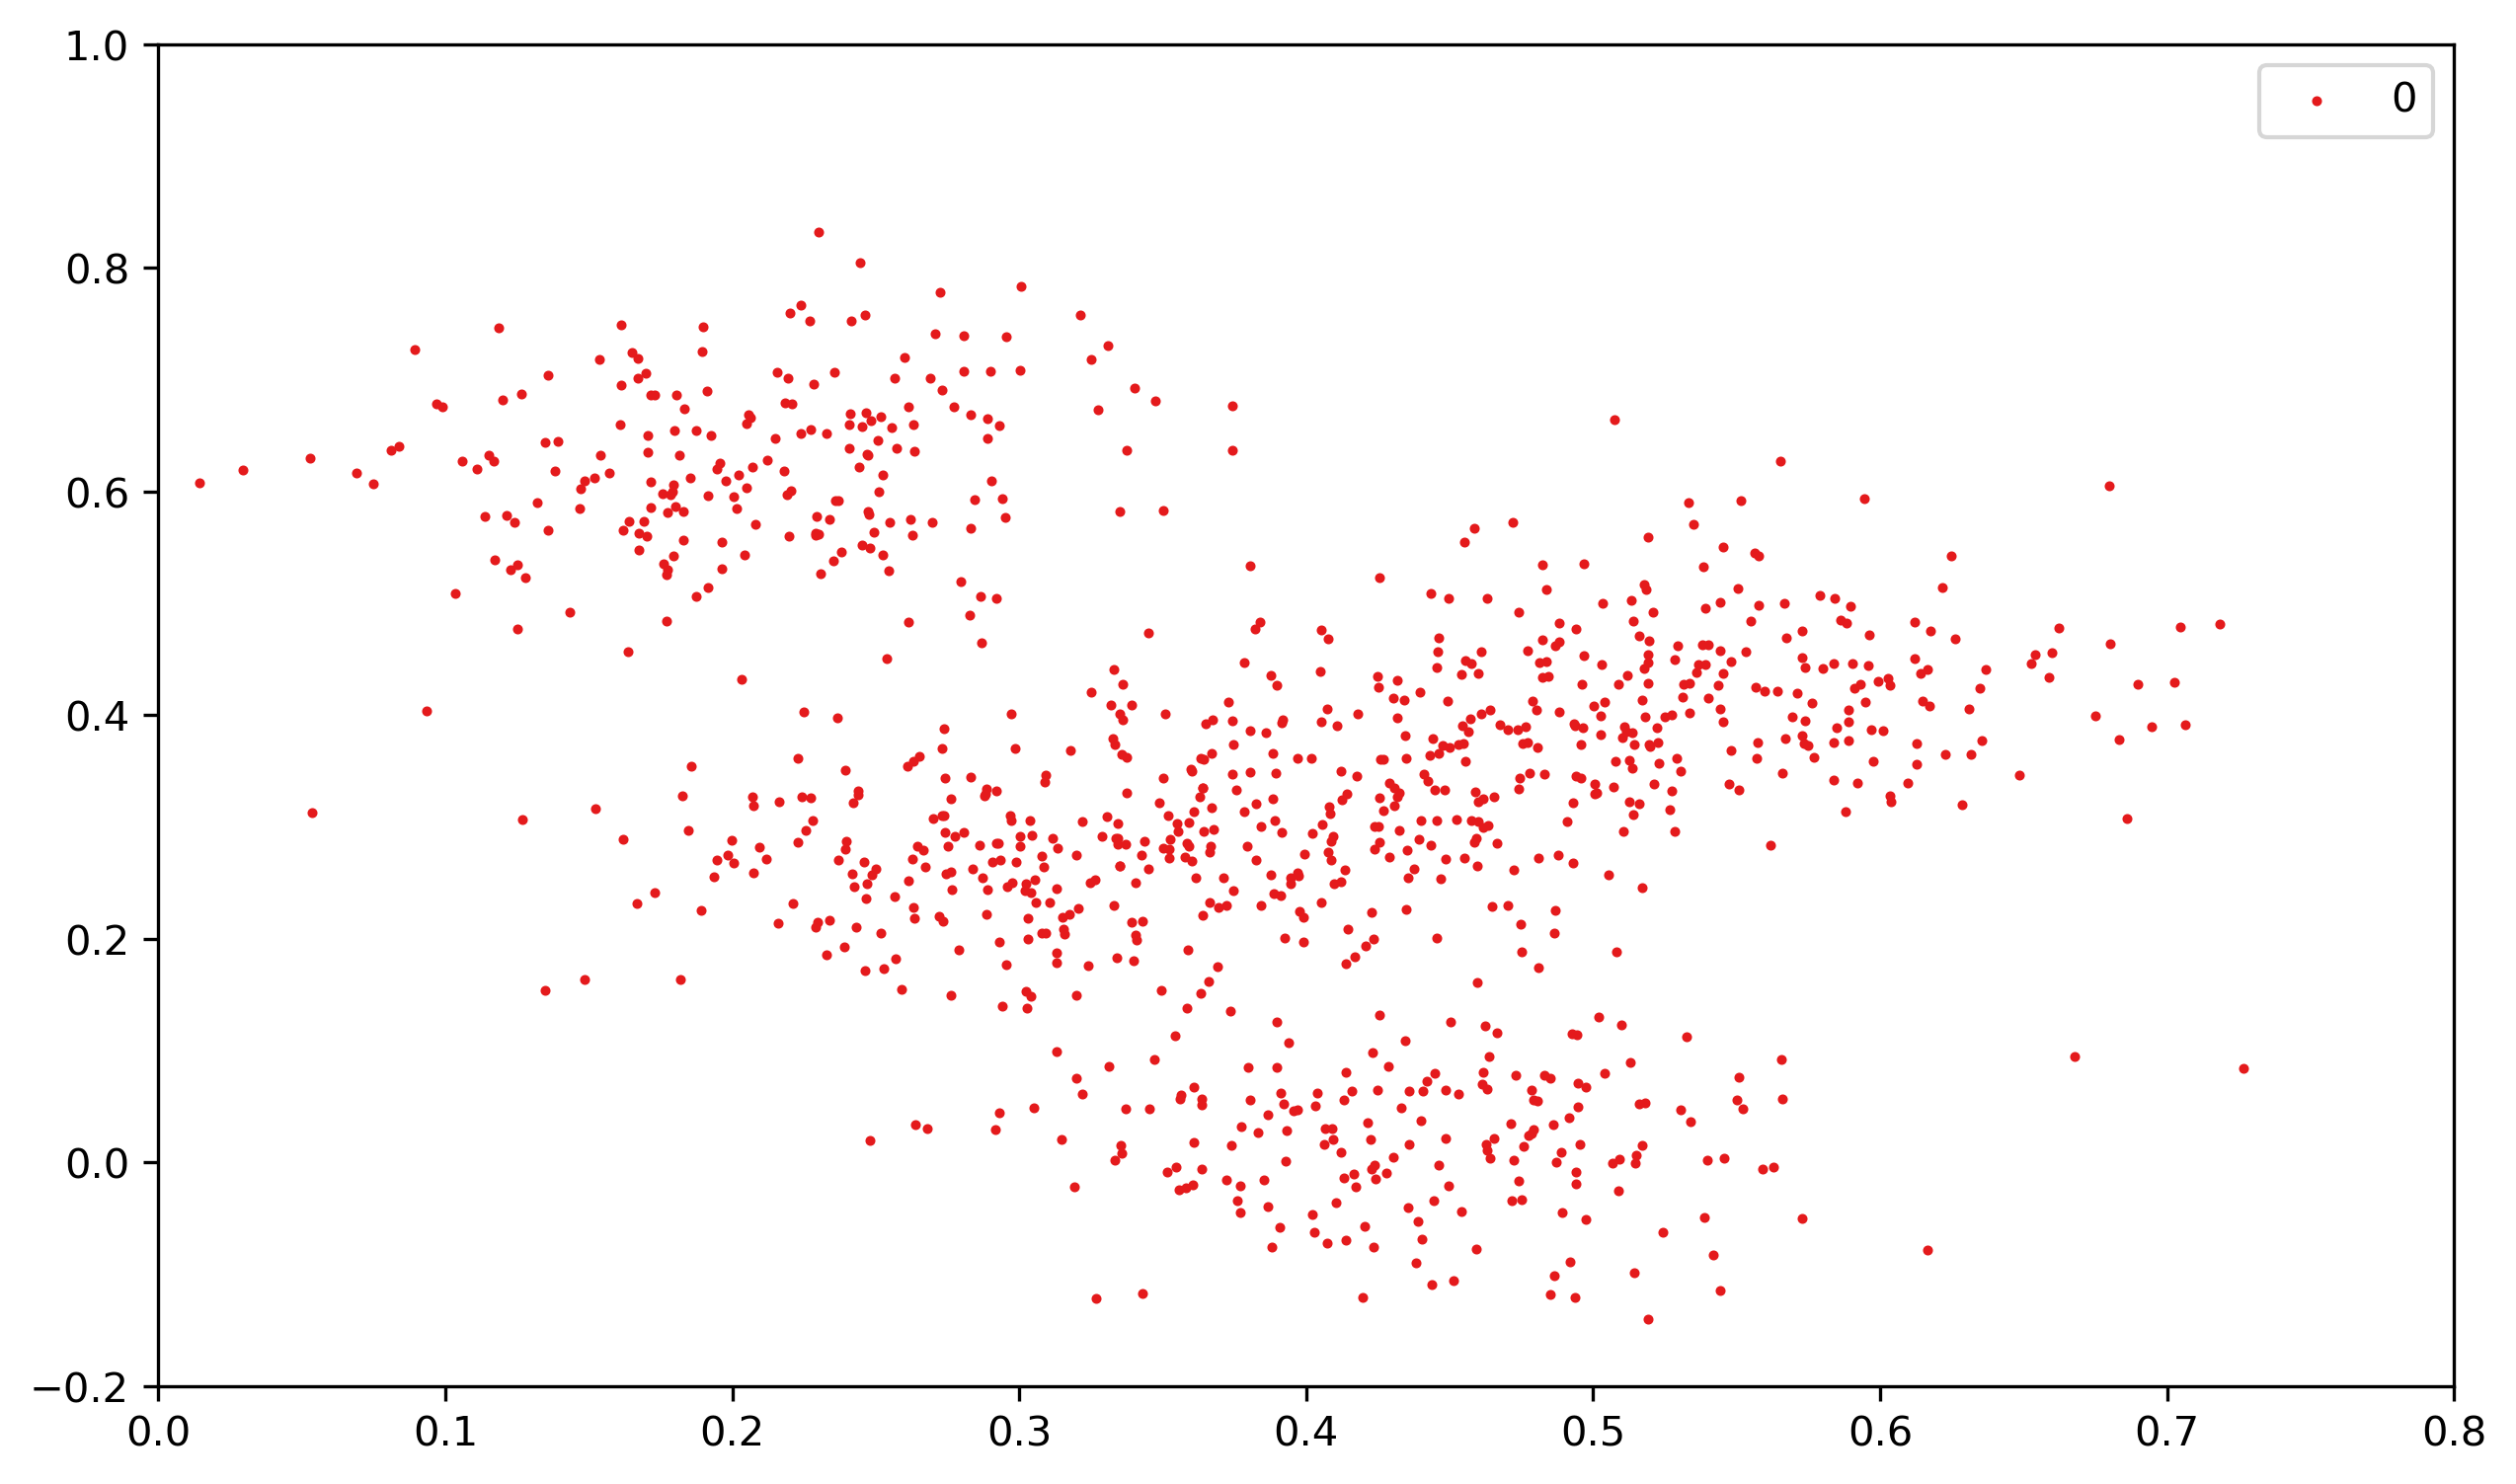

In [28]:
# Check
plt.figure(figsize=(10, 6), dpi=300)
plt.xlim(0, 0.8)
plt.ylim(-0.2, 1.0)
for i in range(num_parties):
    if i == 0:
        plt.scatter(unequal_datasets[i, :, 0], unequal_datasets[i, :, 1], s=2, color=cm.get_cmap('Set1')(i*(1/9)), label="{0}".format(i))

plt.legend()

In [29]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=d))
kernel.base_kernel.lengthscale = [0.02, 0.02]
kernel.outputscale = 1

In [30]:
reference_dataset, reference_labels = sample_GMM(means, covs, num_samples=5000)

In [31]:
perm_samp_dataset, perm_samp_labels = sample_GMM(means, covs, num_samples=5000)

In [32]:
v = get_v(unequal_datasets, reference_dataset, kernel)

In [33]:
v

{'{1}': 0.009762789122760296,
 '{2}': 0.009556821547448635,
 '{3}': -0.003994841128587723,
 '{4}': 0.0023443810641765594,
 '{5}': -6.485916674137115e-05,
 '{1, 2}': 0.01009363029152155,
 '{1, 3}': 0.0067180488258600235,
 '{1, 4}': 0.008244512602686882,
 '{1, 5}': 0.0077228788286447525,
 '{2, 3}': 0.00649262685328722,
 '{2, 4}': 0.008103499189019203,
 '{2, 5}': 0.007832509465515614,
 '{3, 4}': 0.007190686650574207,
 '{3, 5}': 0.008498652838170528,
 '{4, 5}': 0.006792658008635044,
 '{1, 2, 3}': 0.008654715493321419,
 '{1, 2, 4}': 0.009344728663563728,
 '{1, 2, 5}': 0.00926014594733715,
 '{1, 3, 4}': 0.008944517001509666,
 '{1, 3, 5}': 0.009561692364513874,
 '{1, 4, 5}': 0.008777542971074581,
 '{2, 3, 4}': 0.008804540149867535,
 '{2, 3, 5}': 0.009533112868666649,
 '{2, 4, 5}': 0.008786476217210293,
 '{3, 4, 5}': 0.01018258836120367,
 '{1, 2, 3, 4}': 0.009502105414867401,
 '{1, 2, 3, 5}': 0.009932097047567368,
 '{1, 2, 4, 5}': 0.009497529827058315,
 '{1, 3, 4, 5}': 0.010285926051437855,
 '

In [34]:
phi = shapley(v, num_parties)
print(phi)

[0.003630146803334355, 0.0035343390113363664, 0.00014978875406086446, 0.0016751665311555068, 0.0013283967195699613]


In [35]:
alpha = norm(phi)
print(alpha)

[1.0, 0.9736077362188252, 0.04126245085275361, 0.46145972102749017, 0.36593471050531756]


In [65]:
#etas = [0.001, 0.01, 0.1, 1]

# all_sorted_vX = []
# for eta in etas:
#     sorted_vX = perm_sampling_neg_biased(perm_samp_dataset, reference_dataset, kernel, num_perms=200, eta=eta)
#     all_sorted_vX.append(sorted_vX)
#     print("Eta = {} - Mean:{} \\ Median:{}".format(eta, np.mean(sorted_vX), np.median(sorted_vX)))

In [36]:
vN = get_vN(v, num_parties)
print(vN)

0.010317837819457054


In [37]:
v_is = get_v_is(v, num_parties)
print(v_is)

[0.009762789122760296, 0.009556821547448635, -0.003994841128587723, 0.0023443810641765594, -6.485916674137115e-05]


In [40]:
get_alpha_min(alpha)

0.04126245085275361

## All condition

In [62]:
best_eta, q = get_eta_q(vN, alpha, v_is, mode="all")


Iteration 0
current_high=1.0, current_low=0.001
Evaluating for eta = 0.5005



all condition satisfied, setting current_high to 0.5005
Iteration 1
current_high=0.5005, current_low=0.001
Evaluating for eta = 0.25075



all condition satisfied, setting current_high to 0.25075
Iteration 2
current_high=0.25075, current_low=0.001
Evaluating for eta = 0.125875



all condition satisfied, setting current_high to 0.125875
Iteration 3
current_high=0.125875, current_low=0.001
Evaluating for eta = 0.0634375



all condition not satisfied, setting current_low to 0.0634375
Iteration 4
current_high=0.125875, current_low=0.0634375
Evaluating for eta = 0.09465625



all condition not satisfied, setting current_low to 0.09465625
Iteration 5
current_high=0.125875, current_low=0.09465625
Evaluating for eta = 0.11026562499999999



all condition not satisfied, setting current_low to 0.11026562499999999
Iteration 6
current_high=0.125875, current_low=0.11026562499999999
Evaluating for eta = 0.1180703125



all condition not satisfied, setting current_low to 0.1180703125
Iteration 7
current_high=0.125875, current_low=0.1180703125
Evaluating for eta = 0.12197265624999999



all condition not satisfied, setting current_low to 0.12197265624999999
Iteration 8
current_high=0.125875, current_low=0.12197265624999999
Evaluating for eta = 0.123923828125



all condition satisfied, setting current_high to 0.123923828125
Iteration 9
current_high=0.123923828125, current_low=0.12197265624999999
Evaluating for eta = 0.1229482421875



all condition satisfied, setting current_high to 0.1229482421875


In [63]:
best_eta

0.1229482421875

In [60]:
v_is

[0.009762789122760296,
 0.009556821547448635,
 -0.003994841128587723,
 0.0023443810641765594,
 -6.485916674137115e-05]

In [64]:
#all condition
r = list(map(q, alpha))
print(r)

[0.010317837819457054, 0.009621026925742626, 0.007914991118013859, 0.008643414825201035, 0.008504544384777546]


In [65]:
num_candidate_points = 5000
gmm_clusters = [sample_GMM(means, covs, num_candidate_points) for i in range(num_clusters)]
gmm = np.array([pair[0] for pair in gmm_clusters])
clusters = np.array([pair[1] for pair in gmm_clusters])
cand_datasets = np.array([gmm[0]]*num_parties)

In [66]:
greeds = np.ones(num_parties) * 2

In [67]:
rewards, deltas, mus = reward_realization(cand_datasets, 
                                          reference_dataset, 
                                          r, 
                                          unequal_datasets, 
                                          kernel, 
                                          greeds=greeds)

Running weighted sampling algorithm with -MMD^2 target 0.010317837819457054Running weighted sampling algorithm with -MMD^2 target 0.009621026925742626Running weighted sampling algorithm with -MMD^2 target 0.008643414825201035Running weighted sampling algorithm with -MMD^2 target 0.007914991118013859
Running weighted sampling algorithm with -MMD^2 target 0.008504544384777546





In [77]:
pickle.dump((gmm, clusters, reference_dataset, cand_datasets, unequal_datasets, greeds, rewards, deltas, mus), open("results/CGM-GMM-unequal-greed2-all.p", "wb"))

In [68]:
class_props = []
for result in rewards:
        class_props.append(class_proportion(get_classes(np.array(result), gmm[0], clusters[0]), num_clusters))

In [69]:
class_props

[(array([0.20114943, 0.18247126, 0.20545977, 0.21695402, 0.19396552]),
  0.040132448143744226),
 (array([0.27272727, 0.22727273, 0.18181818, 0.13636364, 0.18181818]),
  0.04214876033057851),
 (array([0.11123723, 0.16685585, 0.20998865, 0.25198638, 0.2599319 ]),
  0.04307431061339078),
 (array([0.2816092 , 0.17528736, 0.12787356, 0.20977011, 0.20545977]),
  0.04251965253005681),
 (array([0.27137042, 0.24423338, 0.23202171, 0.13432836, 0.11804613]),
  0.04382098389267429)]

In [75]:
for i in range(num_parties):
    print(mmd_neg_biased(np.concatenate([unequal_datasets[i], np.array(rewards[i])], axis=0), reference_dataset, kernel)[0])

0.010319412685930729
0.00962269026786089
0.007917233742773533
0.008645186200737953
0.008507099002599716


## Max condition

In [78]:
best_eta, q = get_eta_q(vN, alpha, v_is, mode="max")


Iteration 0
current_high=1.0, current_low=0.001
Evaluating for eta = 0.5005



max condition not satisfied, setting current_low to 0.5005
Iteration 1
current_high=1.0, current_low=0.5005
Evaluating for eta = 0.75025



max condition not satisfied, setting current_low to 0.75025
Iteration 2
current_high=1.0, current_low=0.75025
Evaluating for eta = 0.8751249999999999



max condition satisfied, setting current_high to 0.8751249999999999
Iteration 3
current_high=0.8751249999999999, current_low=0.75025
Evaluating for eta = 0.8126875



max condition satisfied, setting current_high to 0.8126875
Iteration 4
current_high=0.8126875, current_low=0.75025
Evaluating for eta = 0.7814687499999999



max condition not satisfied, setting current_low to 0.7814687499999999
Iteration 5
current_high=0.8126875, current_low=0.7814687499999999
Evaluating for eta = 0.797078125



max condition satisfied, setting current_high to 0.797078125
Iteration 6
current_high=0.797078125, current_low=0.7814687499999999
Evaluating for eta = 0.7892734374999999



max condition satisfied, setting current_high to 0.7892734374999999
Iteration 7
current_high=0.7892734374999999, current_low=0.7814687499999999
Evaluating for eta = 0.7853710937499999



max condition not satisfied, setting current_low to 0.7853710937499999
Iteration 8
current_high=0.7892734374999999, current_low=0.7853710937499999
Evaluating for eta = 0.7873222656249999



max condition satisfied, setting current_high to 0.7873222656249999
Iteration 9
current_high=0.7873222656249999, current_low=0.7853710937499999
Evaluating for eta = 0.7863466796874998



max condition satisfied, setting current_high to 0.7863466796874998


In [79]:
best_eta

0.7863466796874998

In [80]:
v_is

[0.009762789122760296,
 0.009556821547448635,
 -0.003994841128587723,
 0.0023443810641765594,
 -6.485916674137115e-05]

In [87]:
#all condition
r = list(map(q, alpha))
print(r)

[0.010317837819457054, 0.010237198323011398, 0.009794521145522594, 0.00998112466186285, 0.009948275052011013]


In [88]:
num_candidate_points = 5000
gmm_clusters = [sample_GMM(means, covs, num_candidate_points) for i in range(num_clusters)]
gmm = np.array([pair[0] for pair in gmm_clusters])
clusters = np.array([pair[1] for pair in gmm_clusters])
cand_datasets = np.array([gmm[0]]*num_parties)

In [89]:
greeds = np.ones(num_parties) * 2

In [90]:
rewards, deltas, mus = reward_realization(cand_datasets, 
                                          reference_dataset, 
                                          r, 
                                          unequal_datasets, 
                                          kernel, 
                                          greeds=greeds)

Running weighted sampling algorithm with -MMD^2 target 0.010317837819457054Running weighted sampling algorithm with -MMD^2 target 0.010237198323011398

Running weighted sampling algorithm with -MMD^2 target 0.009794521145522594Running weighted sampling algorithm with -MMD^2 target 0.00998112466186285

Running weighted sampling algorithm with -MMD^2 target 0.009948275052011013


In [91]:
pickle.dump((gmm, clusters, reference_dataset, cand_datasets, unequal_datasets, greeds, rewards, deltas, mus), open("results/CGM-GMM-unequal-greed2-max.p", "wb"))

In [92]:
class_props = []
for result in rewards:
        class_props.append(class_proportion(get_classes(np.array(result), gmm[0], clusters[0]), num_clusters))

In [93]:
class_props

[(array([0.21223022, 0.20143885, 0.19604317, 0.20143885, 0.18884892]),
  0.040058744371409355),
 (array([0.18703704, 0.1962963 , 0.2037037 , 0.21481481, 0.19814815]),
  0.04008367626886146),
 (array([0.12156216, 0.17931793, 0.22717272, 0.2310231 , 0.24092409]),
  0.0419911628126509),
 (array([0.24385102, 0.18060436, 0.15319747, 0.2073085 , 0.21503865]),
  0.04095383097382674),
 (array([0.23773104, 0.26513703, 0.20458891, 0.15296367, 0.13957935]),
  0.042310118650835726)]

In [94]:
for i in range(num_parties):
    print(mmd_neg_biased(np.concatenate([unequal_datasets[i], np.array(rewards[i])], axis=0), reference_dataset, kernel)[0])

0.010318617336452007
0.010237225331366062
0.009794775396585464
0.009982003830373287
0.009948963299393654
